## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors: Paul Doucet, Jerry Khidaroo

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"Hi, I'm wondering if I can schedule an appointment for an oil change and tune up? Hi there, I'd be happy to help you. Have you had your car serviced with us before? No, I haven't. That's alright, we love getting new customers. What kind of vehicle do you have? Its a 2018 Subaru Impreza. Excellent. Did you have any specific day or time you wanted to come in for that oil change and tune up? What days are you open? We're here Monday through Friday till 6 pm. Okay. I can do any time on Mondays actually. Excellent, that's usually our slowest day. Do you prefer morning or afternoon? Morning would be best. We can get you in for those services next Monday the 18th at 10 am. Would that work for you? Yeah that would be great. Did you want to add any additional services to that tune up and oil change? Car wash, detailing, anything? No that's okay, I will just stick with the tune up and oil change. Alright sounds good. And you also get 20% off these services since you're a first time customer. Wow thank you so much! No problem. Is there anything else I can do for you? No, that's it. Thanks again. Okay great. We will see you Monday the 18th at 10 am for that tune up and oil change on your Subaru. Cool, thanks. Have a good day! You have a good day too. Thanks for choosing us. No problem. Bye! Bye bye!",auto-repair-appt-1,0
126,"Hi there, I need to schedule an appointment to repair my boss's car. Sure, we just need you to answer a few questions before we proceed. Ok. Have you visited here before? Yes. Ok, great, what's your boss's name? Jane Doe. Perfect, I've pulled up your account and I see that you have a 2012 Honda Civic. What seems to be the problem today? Well, it's having trouble starting up. Maybe there's something wrong with the starter? Ok, we can take a look at that for you. We have some openings tomorrow evening around 4, will that work for you? Yes, I can leave here by then. How much do you think it will cost? Hard to tell without looking, but if it is the starter, it will probably run you about $400. Ok. Can you send me a copy of an estimate? Sure, we can do that. Do you have an email address? Sure, it's jane.doe@gmail.com. Ok, jane.doe@gmail.com. Yes, that's correct. Ok, great. Any other questions? No, that's all! Alright, we'll see you tomorrow, Wednesday January 22 at 4, and it will probably be around $400. Great, thanks so much!",auto-repair-appt-1,0
555,"I'd like to order tickets to the Lego Movie 2. Great, which theatre would you like to attend? We have 5 people who'd like to attend at the at Regal Manor Stadium 16 in Lancaster,PA. Would you like to see the movie in 3-D? No thank you, just 2D. Okay, when would you like to attend the movies? We're looking at this evening. What times are available? We have an 8PM and 10PM show. We'd like the 10 PM show please. Would you like to add on a snack package option for an additional $10? No thanks, just the movie. Okay, how many adults and how many children? There will be 2 adults and 3 children. How much is that? It is $7.50 for adults and $6.00 for children for a total of $33.00. I'd like to charge that to my movie credit account. Great, we'll take care of that for you. Thank you. Okay, so your tickets are being sent to your mobile device via text message. Thanks! That is great. I hope you enjoy your Lego Movie 2 tonight at 10PM at Regal Manor Stadium 16 in Lancaster,PA.",movie-tickets-1,1
1260,"Hey man what’s up Not much what ya need ? A reservation I can do that, where at ? The gas house Oh that’s a tough one boss I know just see what’s available Alright, I’ll pull up the website Thank you looking for 6 pm Inside or out Outside Not available Okay so inside, Booth or table Booth for 4 Also not available, how about a table Whatever, it’ll work Okay sorry about that It’s okay I’m in Anything else ? No that’ll do it thanks You got it",restaurant-table-2,2
902,"Can I get some papa murphy's pizza? Yeah sure what do you want me to order? 

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"Hi, I'm wondering if I can schedule an appointment for an oil change and tune up? Hi there, I'd be happy to help you. Have you had your car serviced with us before? No, I haven't. That's alright, we love getting new customers. What kind of vehicle do you have? Its a 2018 Subaru Impreza. Excellent. Did you have any specific day or time you wanted to come in for that oil change and tune up? What days are you open? We're here Monday through Friday till 6 pm. Okay. I can do any time on Mondays actually. Excellent, that's usually our slowest day. Do you prefer morning or afternoon? Morning would be best. We can get you in for those services next Monday the 18th at 10 am. Would that work for you? Yeah that would be great. Did you want to add any additional services to that tune up and oil change? Car wash, detailing, anything? No that's okay, I will just stick with the tune up and oil change. Alright sounds good. And you also get 20% off these services since you're a first time customer. Wow thank you so much! No problem. Is there anything else I can do for you? No, that's it. Thanks again. Okay great. We will see you Monday the 18th at 10 am for that tune up and oil change on your Subaru. Cool, thanks. Have a good day! You have a good day too. Thanks for choosing us. No problem. Bye! Bye bye!",auto-repair-appt-1,0,hi im wondering schedule appointment oil change tune hi id happy help car serviced us havent thats alright love getting new customers kind vehicle subaru impreza excellent specific day time wanted come oil change tune days open monday friday till pm okay time mondays actually excellent thats usually slowest day prefer morning afternoon morning would best get services next monday th would work yeah would great want add additional services tune oil change car wash detailing anything thats okay stick tune oil change alright sounds good also get services since youre first time customer wow thank much problem anything else thats thanks okay great see monday th tune oil change subaru cool thanks good day good day thanks choosing us problem bye bye bye
126,"Hi there, I need to schedule an appointment to repair my boss's car. Sure, we just need you to answer a few questions before we proceed. Ok. Have you visited here before? Yes. Ok, great, what's your boss's name? Jane Doe. Perfect, I've pulled up your account and I see that you have a 2012 Honda Civic. What seems to be the problem today? Well, it's having trouble starting up. Maybe there's something wrong with the starter? Ok, we can take a look at that for you. We have some openings tomorrow evening around 4, will that work for you? Yes, I can leave here by then. How much do you think it will cost? Hard to tell without looking, but if it is the starter, it will probably run you about $400. Ok. Can you send me a copy of an estimate? Sure, we can do that. Do you have an email address? Sure, it's jane.doe@gmail.com. Ok, jane.doe@gmail.com. Yes, that's correct. Ok, great. Any other questions? No, that's all! Alright, we'll see you tomorrow, Wednesday January 22 at 4, and it will probably be around $400. Great, thanks so much!",auto-repair-appt-1,0,hi need schedule appointment repair bosss car sure need answer questions proceed ok visited yes ok great whats bosss name jane doe perfect ive pulled account see honda civic seems problem today well trouble starting maybe theres something wrong starter ok take look openings tomorrow evening around work yes leave much think cost hard tell without looking starter probably run ok send copy estimate sure email address sure janedoegmailcom ok janedoegmailcom yes thats correct ok great questions thats alright well see tomorrow wednesday january probably around great thanks much
555,"I'd like to order tickets to the Lego Movie 2. Great, which theatre would you like to attend? We have 5 people who'd like to attend at the at Regal Manor Stadium 16 in Lancaster,PA. Would you like to s

In [12]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['hi need schedule appointment repair bosss car sure need answer questions proceed ok visited yes ok great whats bosss name jane doe perfect ive pulled account see honda civic seems problem today well trouble starting maybe theres something wrong starter ok take look openings tomorrow evening around work yes leave much think cost hard tell without looking starter probably run ok send copy estimate sure email address sure janedoegmailcom ok janedoegmailcom yes thats correct ok great questions thats alright well see tomorrow wednesday january probably around great thanks much',
 'id like order tickets lego movie great theatre would like attend people whod like attend regal manor stadium lancasterpa would like see movie thank okay would like attend movies looking evening times available pm pm show wed like pm show please would like add snack package option additional thanks movie okay many adults many children adults children much adults children total id like charge movie credit account 

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5902
Vocabulary Sample: [('like', 1), ('would', 2), ('ok', 3), ('yes', 4), ('okay', 5), ('pm', 6), ('want', 7), ('order', 8), ('time', 9), ('tickets', 10)]


#### Build (context_words, target_word) pair generator

In [14]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [15]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['hi', 'im', 'schedule', 'appointment'] -> Target (Y): wondering
Context (X): ['im', 'wondering', 'appointment', 'oil'] -> Target (Y): schedule
Context (X): ['wondering', 'schedule', 'oil', 'change'] -> Target (Y): appointment
Context (X): ['schedule', 'appointment', 'change', 'tune'] -> Target (Y): oil
Context (X): ['appointment', 'oil', 'tune', 'hi'] -> Target (Y): change
Context (X): ['oil', 'change', 'hi', 'id'] -> Target (Y): tune
Context (X): ['change', 'tune', 'id', 'happy'] -> Target (Y): hi
Context (X): ['tune', 'hi', 'happy', 'help'] -> Target (Y): id
Context (X): ['hi', 'id', 'help', 'car'] -> Target (Y): happy
Context (X): ['id', 'happy', 'car', 'serviced'] -> Target (Y): help
Context (X): ['happy', 'help', 'serviced', 'us'] -> Target (Y): car


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [16]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 8, 4, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 4, ..., 0, 0, 1],
       [0, 6, 5, ..., 0, 0, 0]], dtype=int64)

In [19]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,ok,yes,okay,pm,want,order,time,tickets,thank,please,one,great,...,nodumb,dumber,geniusyou,effects,enquire,timings,sections,tub,hotdog,vouchers,caseys,nypd,backed,elizabeths,hoped
0,0,0,3,0,0,3,1,1,0,3,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,6,3,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,8,4,0,0,3,4,0,1,0,2,2,1,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,3,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,5,0,0,0,4,2,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,2,0,1,0,0,1,6,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
996,0,0,0,0,2,2,7,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
997,0,0,0,0,0,6,2,0,1,2,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,5,4,1,3,3,1,0,1,1,3,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [20]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5902)
(250, 5902)
(250,)


#### Define Model Builder Function

In [21]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()

    return cm, pred, f1, report, accuracy

## Bag of Words Features Baseline Benchmarking with LinearSVC Classifier

In [22]:
from sklearn.svm import LinearSVC

model_svc_bow = LinearSVC()
cm_svc_bow, pred_svc_bow, f1_svc_bow, report_svc_bow, accuracy_svc_bow = Build_Model(model_svc_bow, X_train_bow, y_train, X_test_bow, y_test)

In [32]:
# Save benchmark output
rows_benchmarks = []
rows_benchmarks.append(["BOW LinearSVC All Features", f1_svc_bow, accuracy_svc_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.60,0.61


In [23]:
from sklearn.metrics import confusion_matrix

cm_svc_bow

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0, 14, 10,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  6,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  9,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 12,  6,  2,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 10,  2,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  2,  3, 19,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0,  1, 13,  5,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  3,  6,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  6,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 12]],
      dtype=int64)

In [24]:
print(accuracy_svc_bow)

0.612


In [26]:
from sklearn import metrics

print(report_svc_bow)

precision    recall  f1-score   support

auto-repair-appt-1       0.95      1.00      0.97        18
 coffee-ordering-1       0.56      0.74      0.64        19
 coffee-ordering-2       0.46      0.38      0.41        16
      movie-finder       0.82      0.82      0.82        11
   movie-tickets-1       0.55      0.60      0.57        20
   movie-tickets-2       0.56      0.45      0.50        22
   movie-tickets-3       0.76      0.79      0.78        24
  pizza-ordering-1       0.53      0.57      0.55        14
  pizza-ordering-2       0.70      0.61      0.65        23
restaurant-table-1       0.54      0.59      0.57        22
restaurant-table-2       0.43      0.35      0.39        17
restaurant-table-3       0.39      0.44      0.41        16
       uber-lyft-1       0.83      0.33      0.48        15
       uber-lyft-2       0.60      0.92      0.73        13

          accuracy                           0.61       250
         macro avg       0.62      0.61      0.60       25

#### Bag of Words Feature Benchmarking with Naive Bayes Classifier

In [30]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
cm_nb_bow, pred_nb_bow, f1_nb_bow, report_nb_bow, accuracy_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [33]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes All Features", f1_nb_bow, accuracy_nb_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.60,0.61
1,BOW Naive Bayes All Features,0.71,0.70


In [34]:
from sklearn.metrics import confusion_matrix

cm_nb_bow

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 14,  6,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  6, 15,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 19,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  4,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 11,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  8]],
      dtype=int64)

In [35]:
from sklearn import metrics

print(report_nb_bow)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.85      0.58      0.69        19
 coffee-ordering-2       0.64      0.88      0.74        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.58      0.70      0.64        20
   movie-tickets-2       0.65      0.68      0.67        22
   movie-tickets-3       0.95      0.79      0.86        24
  pizza-ordering-1       0.53      0.64      0.58        14
  pizza-ordering-2       0.75      0.65      0.70        23
restaurant-table-1       0.75      0.68      0.71        22
restaurant-table-2       0.48      0.65      0.55        17
restaurant-table-3       0.67      0.50      0.57        16
       uber-lyft-1       0.64      0.60      0.62        15
       uber-lyft-2       0.57      0.62      0.59        13

          accuracy                           0.70       250
         macro avg       0.72      0.71      0.71       25

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Function

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MinMaxScaler().fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

#### Iterate through number of features and get benchmark results

In [97]:
rows = []
for i in range(250, 5920, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(naive, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

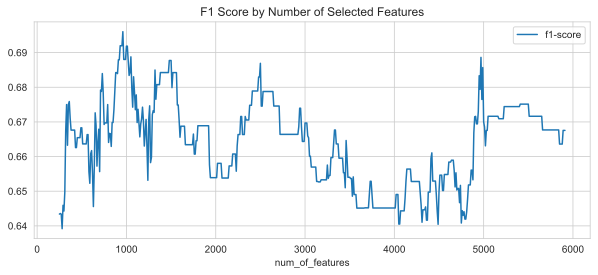

In [98]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [99]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1-score
71,960,0.70
70,950,0.69
69,940,0.69
68,930,0.69
75,1000,0.69


#### Get a more fine-grained look at the optimal number of features region

In [91]:
rows = []
for i in range(930, 990, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(naive, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

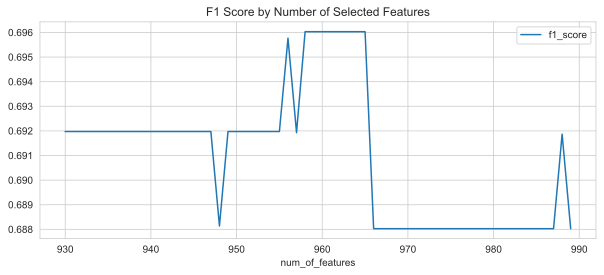

In [92]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [93]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
30,960,0.70,0.70
32,962,0.70,0.70
28,958,0.70,0.70
31,961,0.70,0.70
29,959,0.70,0.70


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [39]:
model_nb_bow_opt = MultinomialNB()
cm_optimal, pred_opt, f1_opt, report_opt, accuracy_opt = SelectBestModelFeatures_Chi(model_nb_bow_opt, 960, X_train_bow, y_train, X_test_bow, y_test)

In [40]:
print(cm_optimal)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8 13  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 15  6  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  5 11  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5 19  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3 16  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 12  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  6 12  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  3  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10 12]]


In [41]:
print(report_opt)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.79      0.58      0.67        19
 coffee-ordering-2       0.62      0.81      0.70        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.62      0.75      0.68        20
   movie-tickets-2       0.58      0.50      0.54        22
   movie-tickets-3       0.79      0.79      0.79        24
  pizza-ordering-1       0.61      0.79      0.69        14
  pizza-ordering-2       0.84      0.70      0.76        23
restaurant-table-1       0.86      0.55      0.67        22
restaurant-table-2       0.48      0.71      0.57        17
restaurant-table-3       0.56      0.56      0.56        16
       uber-lyft-1       0.83      0.33      0.48        15
       uber-lyft-2       0.55      0.92      0.69        13

          accuracy                           0.70       250
         macro avg       0.72      0.71      0.70       25

In [42]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes Optimal Features Selected: 960", f1_opt, accuracy_opt])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.60,0.61
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 960,0.69,0.70


## TF-IDF Feature Extraction

In [44]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
#vocab_tfidf = count_vect.vocabulary_
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 5065)
(250, 5065)


## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [45]:
clf = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_tfidf, pred_nb_tfidf, f1_nb_tfidf, report_nb_tfidf, accuracy_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Make Some Predictions

In [46]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 5065)


array(['auto-repair-appt-1'], dtype='<U18')

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [47]:
from sklearn.metrics import confusion_matrix

cm_nb_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3, 16,  8,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  4, 12,  7,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2, 14,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 18,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 12,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12, 12]],
      dtype=int64)

In [48]:
from sklearn import metrics

print(report_nb_tfidf)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.00      0.00      0.00        19
 coffee-ordering-2       0.46      1.00      0.63        16
      movie-finder       1.00      0.09      0.17        11
   movie-tickets-1       0.53      0.80      0.64        20
   movie-tickets-2       0.40      0.55      0.46        22
   movie-tickets-3       0.88      0.58      0.70        24
  pizza-ordering-1       0.62      0.57      0.59        14
  pizza-ordering-2       0.75      0.78      0.77        23
restaurant-table-1       0.89      0.36      0.52        22
restaurant-table-2       0.39      0.71      0.50        17
restaurant-table-3       0.47      0.44      0.45        16
       uber-lyft-1       0.75      0.20      0.32        15
       uber-lyft-2       0.50      0.92      0.65        13

          accuracy                           0.58       250
         macro avg       0.62      0.57      0.53       25

In [49]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes All Features", f1_nb_tfidf, accuracy_nb_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.60,0.61
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 960,0.69,0.70
3,TF-IDF Naive Bayes All Features,0.54,0.58


In [56]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

def SelectBestModelFeatures_Chi_sparse(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MaxAbsScaler().fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

## Feature Selection - TF-IDF with Naive Bayes Multinomial

In [57]:
rows = []
for i in range(50, 5060, 100): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

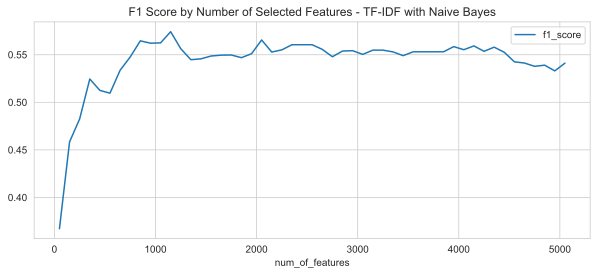

In [58]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [59]:
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
11,1150,0.57,0.61
20,2050,0.57,0.61
8,850,0.56,0.60
10,1050,0.56,0.60
9,950,0.56,0.60


#### Take closer look at region around 1150 features

In [60]:
rows = []
for i in range(1100, 1200, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

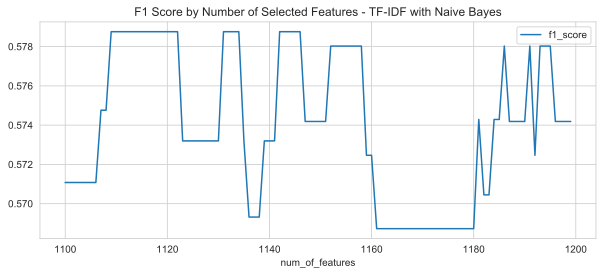

In [62]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [61]:
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
15,1115,0.58,0.62
13,1113,0.58,0.62
33,1133,0.58,0.62
34,1134,0.58,0.62
22,1122,0.58,0.62


#### Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [64]:
cm_tf_nb, pred_tf_nb, f1_tf_nb, report_tf_nb, accuracy_tf_nb = SelectBestModelFeatures_Chi_sparse(clf, 1115, X_train_tfidf, y_train, X_test_tfidf, y_test)
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes Optimal Features Selected: 1115", f1_tf_nb, accuracy_tf_nb])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.60,0.61
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 960,0.69,0.70
3,TF-IDF Naive Bayes All Features,0.54,0.58
4,TF-IDF LinearSVC All Features,0.68,0.69
5,TF-IDF Naive Bayes All Features,0.54,0.58
6,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.58,0.62


## TF-IDF Benchmarking with LinearSVC

In [50]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

model_svc_tfidf = LinearSVC()
cm_svc_tfidf, pred_svc_tfidf, f1_svc_tfidf, report_svc_tfidf, accuracy_svc_tfidf = Build_Model(model_svc_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Show Confusion Matrix Heat Map for TF-IDF LinearSVC baseline

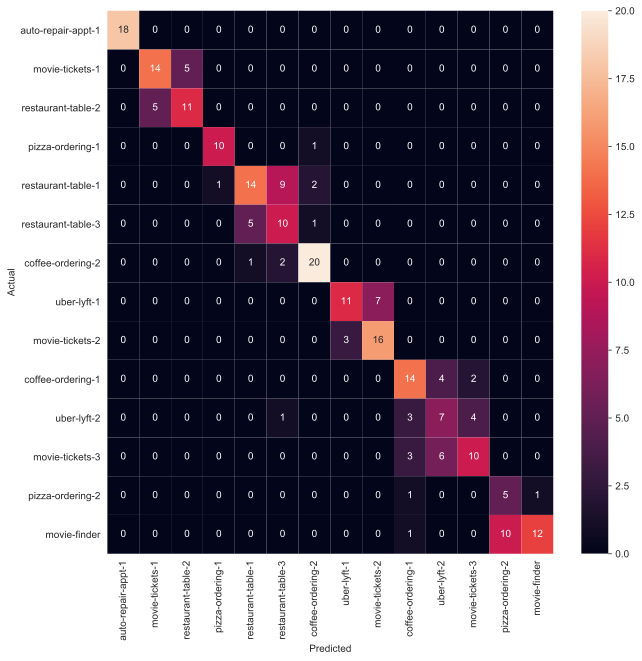

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_svc_tfidf, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Confusion Matrix for Linear SVC on TF-IDF features

In [52]:
cm_svc_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 14,  9,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 10,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  2, 20,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3, 16,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 14,  4,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  3,  7,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  6, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  5,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, 10, 12]],
      dtype=int64)

In [54]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF LinearSVC All Features", f1_svc_tfidf, accuracy_svc_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.60,0.61
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 960,0.69,0.70
3,TF-IDF Naive Bayes All Features,0.54,0.58
4,TF-IDF LinearSVC All Features,0.68,0.69


#### Metrics For Each Class

In [65]:
from sklearn import metrics
print(report_svc_tfidf)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.74      0.74      0.74        19
 coffee-ordering-2       0.69      0.69      0.69        16
      movie-finder       0.91      0.91      0.91        11
   movie-tickets-1       0.54      0.70      0.61        20
   movie-tickets-2       0.62      0.45      0.53        22
   movie-tickets-3       0.87      0.83      0.85        24
  pizza-ordering-1       0.61      0.79      0.69        14
  pizza-ordering-2       0.84      0.70      0.76        23
restaurant-table-1       0.70      0.64      0.67        22
restaurant-table-2       0.47      0.41      0.44        17
restaurant-table-3       0.53      0.62      0.57        16
       uber-lyft-1       0.71      0.33      0.45        15
       uber-lyft-2       0.52      0.92      0.67        13

          accuracy                           0.69       250
         macro avg       0.70      0.70      0.68       25

#### Word2Vec Feature Extraction

In [40]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['clutch', 'contected', 'dealership', 'rain', 'covered'],
 'pizza': ['sausage', 'hut', 'toppings', 'zucchini', 'xlarge'],
 'terminator': ['judgment', 'abyss', 'avatar', 'sigourney', 'vi'],
 'star': ['highest', 'wars', 'rating', 'country', 'starship'],
 'audi': ['fletcher', 'shift', 'constantly', 'steering', 'accessed'],
 'east': ['denver', 'seasons', 'centre', 'greensboro', 'chicago'],
 'korean': ['bbq', 'bbgo', 'lauderhill', 'kansas', 'honey'],
 'playing': ['movie', 'dumbo', 'support', 'central', 'apollo']}

#### Visualizing word embeddings

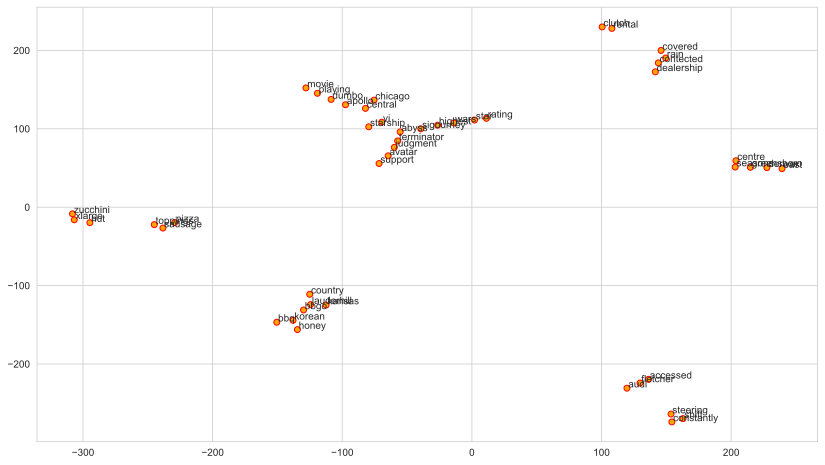

In [41]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [42]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [43]:
w2v_model.wv['jedi']

array([-0.12386877, -0.18022077,  0.13629217, -0.19519687,  0.3317206 ,
        0.00069295,  0.24395373, -0.3781109 ,  0.06554157,  0.42532593,
        0.20056772,  0.09119608, -0.15625575,  0.4736171 , -0.7117875 ,
        0.10899312,  0.00242457, -0.45726466,  0.10529283, -0.25862002,
       -0.42094752,  0.5121968 , -0.05237279, -0.90652514, -0.14884688,
        0.42004946,  0.06401213, -0.3180457 , -0.41755238, -0.461846  ,
        0.20633754,  0.16488461,  0.38565844,  0.23672952,  0.04432544,
       -0.14952208, -0.77574533,  0.4833171 ,  0.00396687, -0.12313127,
       -0.45220608,  0.2631155 , -0.13137814, -0.6397368 ,  0.14818981,
        0.3318139 ,  0.06218205,  0.7651859 ,  0.2695103 , -0.49214005,
       -0.8230682 ,  0.71564895,  0.1005525 ,  0.2685369 , -0.4538102 ,
        0.222405  , -0.07698992,  0.7197483 ,  0.01907734, -0.1331166 ,
       -0.61503625,  0.38384575, -0.45135337,  0.18665229,  0.04427072,
       -0.03228565,  0.35671657,  0.37524447,  0.5474545 ,  0.37

#### Build framework for getting document level embeddings

In [44]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [45]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.26,0.42,0.06,-0.33,0.65,0.01,-0.23,-0.17,0.02,0.16,-0.75,1.03,0.92,-0.91,0.11,...,-0.70,-0.10,-0.74,0.01,0.79,-0.65,0.51,-0.09,0.37,-0.10,-0.13,-0.18,0.31,-0.90,0.14
1,-0.68,0.99,-0.92,-0.82,-0.55,0.24,-0.08,0.46,-0.10,-0.42,-0.50,-0.48,-0.50,0.42,-0.31,...,0.49,-0.97,0.23,0.56,-0.38,0.22,-0.46,-0.95,-0.76,-0.75,-0.46,0.07,0.40,-0.02,-0.42
2,-0.39,0.02,-1.15,-0.53,-0.08,0.24,-0.09,0.40,0.03,-0.83,0.16,0.45,0.41,0.24,-0.78,...,-0.44,-0.09,-0.15,-0.24,-0.09,-0.92,-0.42,-0.06,0.09,-0.88,-0.23,0.08,0.79,-0.11,0.49
3,0.27,-0.01,-0.67,-0.04,0.06,-0.86,0.96,-0.52,-0.15,-0.33,0.18,1.00,1.37,0.07,-1.20,...,-0.12,0.88,-0.41,0.29,-0.39,0.07,-0.57,-0.54,-0.41,-1.33,-0.03,-0.36,0.83,-0.93,0.50
4,0.09,-0.34,-0.31,0.01,0.04,-1.09,0.97,0.17,-0.51,-0.25,-0.02,0.91,0.78,0.04,-1.67,...,0.18,1.13,-0.40,-0.66,0.23,-0.38,0.33,-0.04,-0.32,-1.44,0.14,-0.51,0.73,-0.41,-0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.67,0.03,-1.25,-0.45,0.31,0.22,0.35,-0.57,-0.18,-0.40,0.29,-0.24,0.42,0.46,-1.16,...,-0.76,-0.20,0.11,-0.14,-0.20,-0.37,-0.31,-0.36,0.48,-0.39,-0.02,0.63,1.26,-0.30,0.54
746,-0.25,-0.28,-1.35,0.09,0.35,1.12,0.02,-0.18,0.18,-0.22,0.26,-0.18,-0.57,-0.34,-0.42,...,-0.76,-0.43,0.45,0.85,-0.31,0.91,-0.32,-1.04,-0.37,-0.24,0.09,0.35,0.53,-0.11,-0.39
747,-0.60,0.32,-1.34,-0.35,-0.43,0.31,-0.04,0.15,0.39,-0.63,0.23,-0.33,0.16,0.35,-0.66,...,-0.60,-0.91,0.26,0.11,-0.25,-0.25,-0.25,-0.56,-0.00,-0.33,-0.08,0.64,1.27,0.00,1.05
748,-0.63,-0.00,-0.73,-0.24,-0.07,0.26,0.23,0.14,-0.45,-0.12,-0.27,0.84,1.01,-0.04,-0.66,...,-0.63,-0.40,-0.37,-0.01,-0.43,0.31,-0.11,-0.69,0.01,-0.55,0.48,0.30,0.78,-1.33,0.27


In [46]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


#### Word2vec Feature Benchmarking with LinearSVC Classifier

In [47]:
from sklearn.svm import LinearSVC

model_w2v = LinearSVC()
classifier = model_w2v.fit(w2v_feature_array, y_train)
predict_w2v = classifier.predict(w2v_test_array)

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predict_w2v,y_test)
cm

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 15,  1,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 18,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2, 21,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  9,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 11,  1,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 11,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  5,  6,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, 11,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3, 11]],
      dtype=int64)

In [49]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_w2v, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.70      0.74      0.72        19
restaurant-table-2       0.67      0.62      0.65        16
  pizza-ordering-1       0.90      0.82      0.86        11
restaurant-table-1       0.83      0.75      0.79        20
restaurant-table-3       0.75      0.82      0.78        22
 coffee-ordering-2       0.91      0.88      0.89        24
       uber-lyft-1       0.44      0.57      0.50        14
   movie-tickets-2       0.70      0.61      0.65        23
 coffee-ordering-1       0.73      0.50      0.59        22
       uber-lyft-2       0.41      0.65      0.50        17
   movie-tickets-3       0.43      0.38      0.40        16
  pizza-ordering-2       0.79      0.73      0.76        15
      movie-finder       0.79      0.85      0.81        13

          accuracy                           0.71       250
         macro avg       0.72      0.71      0.71       25

## Additional Advanced Methods To Explore Further

#### GloVe Embeddings with spaCy

In [50]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [51]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
continental,0.24,0.05,0.88,-0.08,0.66,-0.10,-0.02,0.64,-0.50,1.30,-0.57,-0.15,-0.41,0.60,0.66,...,0.55,-0.01,0.16,0.03,0.27,-0.10,0.62,-0.12,-0.47,0.40,0.03,0.71,0.03,-0.62,-0.05
rows,0.69,0.09,-0.64,-0.02,0.52,0.12,-0.11,0.40,-0.30,0.30,0.29,0.23,0.12,-0.04,0.11,...,-0.10,-0.01,0.09,0.26,-0.29,0.24,0.23,-0.02,-0.27,-0.68,0.10,-0.30,0.04,0.48,0.08
wines,-0.87,0.02,0.36,-1.26,1.01,0.39,0.53,0.43,-0.38,1.68,-0.11,0.82,-0.51,-0.54,0.32,...,0.73,0.52,0.34,-0.04,0.80,0.32,0.92,-0.71,0.18,-0.42,-0.88,0.55,-0.68,1.03,-0.19
artists,0.05,-0.34,0.20,-0.16,-0.02,-0.05,0.03,0.22,-0.28,2.49,0.31,-0.05,-0.20,-0.20,0.53,...,0.26,0.52,0.14,-0.09,0.03,-0.74,-0.19,0.08,0.51,-0.16,-0.21,0.18,-0.04,0.13,0.49
rebel,0.08,-0.30,0.33,-0.03,0.32,-0.48,-0.80,0.60,-0.06,1.54,-0.11,-0.34,-0.65,-0.45,-0.06,...,-0.08,0.21,0.52,0.09,0.05,-0.59,0.21,-0.01,-0.39,-0.21,0.26,0.13,0.42,-0.11,-0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pads,0.50,0.44,-0.43,-0.02,-0.11,0.16,0.04,-0.17,0.03,0.07,0.61,0.25,0.15,0.29,-0.26,...,-0.61,-0.51,-0.32,-0.44,-0.55,-0.09,0.04,0.45,-0.25,-0.22,-0.07,0.41,0.12,0.71,-0.29
title,-0.27,-0.11,-0.44,0.06,0.07,-0.09,-0.02,-0.22,0.02,1.84,-0.50,0.73,0.39,-0.01,0.49,...,-0.06,-0.26,0.32,0.26,-0.56,0.21,-0.47,-0.39,-0.18,0.51,0.08,-0.25,-0.66,0.30,-0.37
closest,0.52,-0.47,-0.28,0.34,0.92,-0.35,-0.12,0.58,0.24,2.27,-0.05,0.34,0.04,-0.11,0.18,...,-0.05,-0.43,-0.35,-0.19,0.16,0.11,0.07,-0.10,0.42,0.28,0.10,0.01,-0.32,-0.10,0.55
dixon,-0.22,1.19,-0.16,-0.57,0.35,-0.57,0.02,-0.21,-0.03,-0.36,0.31,-0.31,0.39,-0.45,-0.37,...,-0.02,0.08,-0.08,-0.02,-0.37,0.29,0.27,0.24,-0.26,0.25,-0.20,0.37,0.05,-0.44,-0.02


In [52]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words])
print(word_glove_vectors_test.shape)

(5091, 300)


#### Word2vec features with Fastext Model

In [53]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [54]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['dinner', 'capital', 'food', 'thinking', 'eat'],
 'pizza': ['pepperoni', 'cheese', 'crust', 'sausage', 'large'],
 'terminator': ['nevermind',
  'terrific',
  'event',
  'unfortunately',
  'confirming'],
 'star': ['wars', 'born', 'oct', 'fresno', 'rating'],
 'audi': ['weird', 'wrong', 'model', 'jones', 'appointment'],
 'east': ['requested', 'atlanta', 'chicago', 'suppose', 'places'],
 'korean': ['bbq', 'pig', 'accommodate', 'requests', 'alex'],
 'playing': ['movie', 'showing', 'tickets', 'show', 'theater']}

#### PCA on Fasttext Model

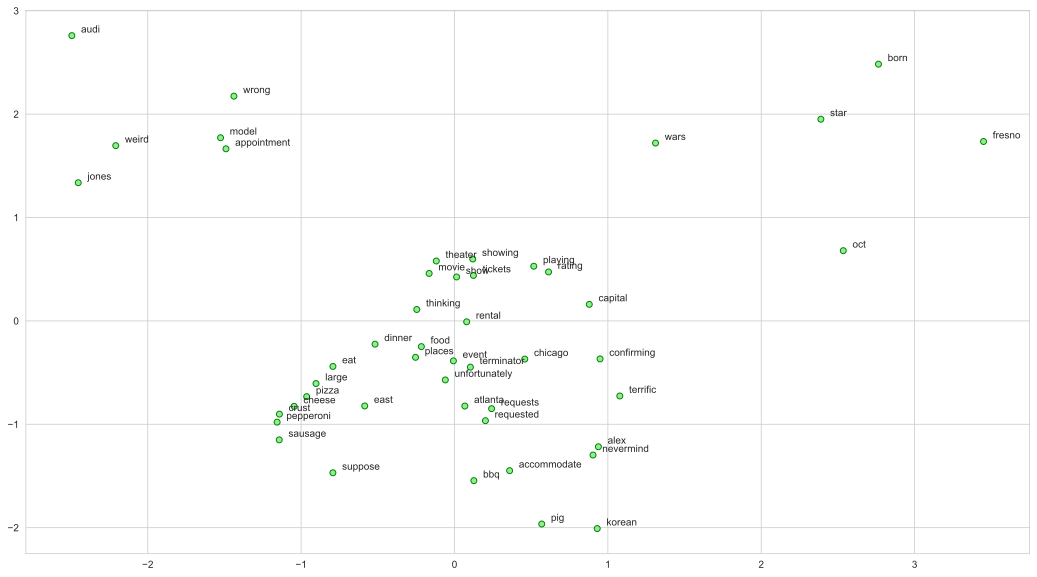

In [55]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [56]:
ft_model.wv['rental']

array([-0.2456603 , -0.3847549 ,  0.06492562,  0.04740023, -0.05075805,
       -0.22694312,  0.4215116 , -0.33982405, -0.04370858,  0.0629853 ,
       -0.3409566 ,  0.00812502, -0.0774149 ,  0.48186895,  0.21284053,
        0.3371108 , -0.25463784, -0.17870781,  0.18154614, -0.40187714,
       -0.11597514,  0.06976771, -0.2827826 ,  0.34207228,  0.11847469,
        0.09189652,  0.4980718 , -0.389526  , -0.03210843, -0.16801834,
       -0.6243001 ,  0.18326154,  0.2597041 , -0.03512648, -0.03855328,
       -0.23020533, -0.21311814,  0.24731663, -0.12095507,  0.21898097,
       -0.03530402,  0.11089047,  0.38267976, -0.03408687,  0.47464603,
        0.13449542,  0.16546832, -0.0557306 , -0.17744146, -0.08903551,
       -0.1279476 , -0.05045699,  0.1012897 , -0.2515585 , -0.06074018,
        0.3012346 ,  0.2712584 ,  0.00910348, -0.2822897 ,  0.10751042,
        0.1602443 ,  0.05004477, -0.39422616, -0.19322552,  0.03605143,
       -0.2429987 , -0.26940596, -0.05992399, -0.18235217, -0.04

In [57]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.103287175
0.7937065


In [58]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies
